# ODI Data Processing
---
Glenn Abastillas | April 7, 2020

**Description** : Process and merge disparate sources of data for visualization in other notebooks.

In [143]:
from pathlib import Path
from glob import glob
from shapely import geometry
import missingno as msg
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import json

#### Define Data Folders and Paths

In [60]:
data = Path('../data')

datasets = data / 'datasets'
datasets_covid = [('regions', 'Regions_Covid', 'csv'), ('unicef', 'UNICEF GB', 'csv')]
datasets_demographics = [('socio-economic', 'SocioEconomic', 'csv'), ('population', 'population', 'csv')]
datasets_health = [('centers', 'healthcenters', 'csv'), ('food-security', 'FoodSecurity', 'csv'), ('sites', 'Healthsites', 'json')]

maps = data / 'maps'
maps_folders = ['health centers', 'regions', 'roads', 'schools', 'sectors']  # Excluding 'sanitary areas'
maps_subfolders = [maps / _ for _ in maps_folders]

#### Define Data Sources

In [72]:
# Helper functions to load string data
get_shp = lambda path_ : glob((path_ / '*.shp').as_posix())[0]
get_dat = lambda key, ext : glob((datasets / f'*{key}*{ext}').as_posix())[0]

# Shape Files for plotting map visualizations
shape_files = {folder.name : get_shp(folder) for folder in maps_subfolders}

# Data files to bind with Shape Files for visualizations
data_files = {
                'covid' : {name : get_dat(key, ext) for name, key, ext in datasets_covid},
                'demographics' : {name : get_dat(key, ext) for name, key, ext in datasets_demographics},
                'health' : {name : get_dat(key, ext) for name, key, ext in datasets_health},
             }

#### Load Data Sources

Load shape files

In [73]:
health_centers, regions, roads, schools, sectors = [gpd.read_file(shape_files[_]) for _ in maps_folders]

Load data frames

In [76]:
covid_regions, covid_unicef = [pd.read_csv(_) for _ in data_files['covid'].values()]
demographics_socioeconomic, demographics_population = [pd.read_csv(_) for _ in data_files['demographics'].values()]
health_centers, health_foodsecurity = [pd.read_csv(_) for k, _ in data_files['health'].items() if k != 'sites']
# health_sites= pd.read_json(data_files['health']['sites'])

#### Inspect Maps

Summary
  * `region` and `roads` are readily mappable. 
  * `schools` has an issue with poorly mapped `long` values causing it to plot around the international date line.
  * `health_centers` requires you indicate `lat` and `long` appropriately. 
  * `health_sites` is lacking an `shx` file and will not load properly.
  
**Regions and Roads**

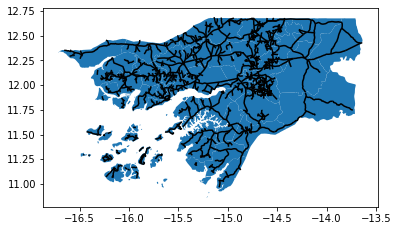

In [97]:
%matplotlib inline
fig, ax = plt.subplots()

# Region and roads are good to go
regions.plot(ax=ax); roads.plot(ax=ax, color='black'); # schools.plot(ax=ax)

**Schools**

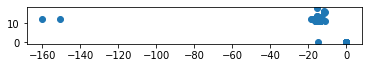

In [96]:
# Need to normalize schools data
schools.plot()

**Health Centers**

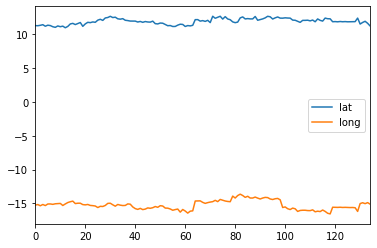

In [130]:
# Health centers does not plot well here, need to indicate to plot by 'lat' and 'long'
health_centers.plot()

For example:

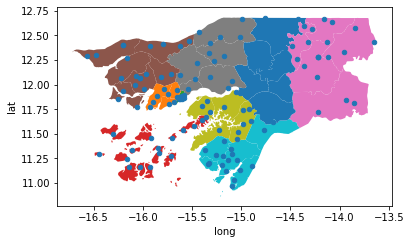

In [132]:
reg_ = regions.plot(column='ADM1_NAME')
health_centers.plot(x='long', y='lat', kind='scatter', ax=reg_)

#### Inspect Data Files

Summary
  * `covid_regions` has a lot of missing data.
  * `covid_unicef` contains the same columns as regions with no augmentation
  

**Covid Regions**

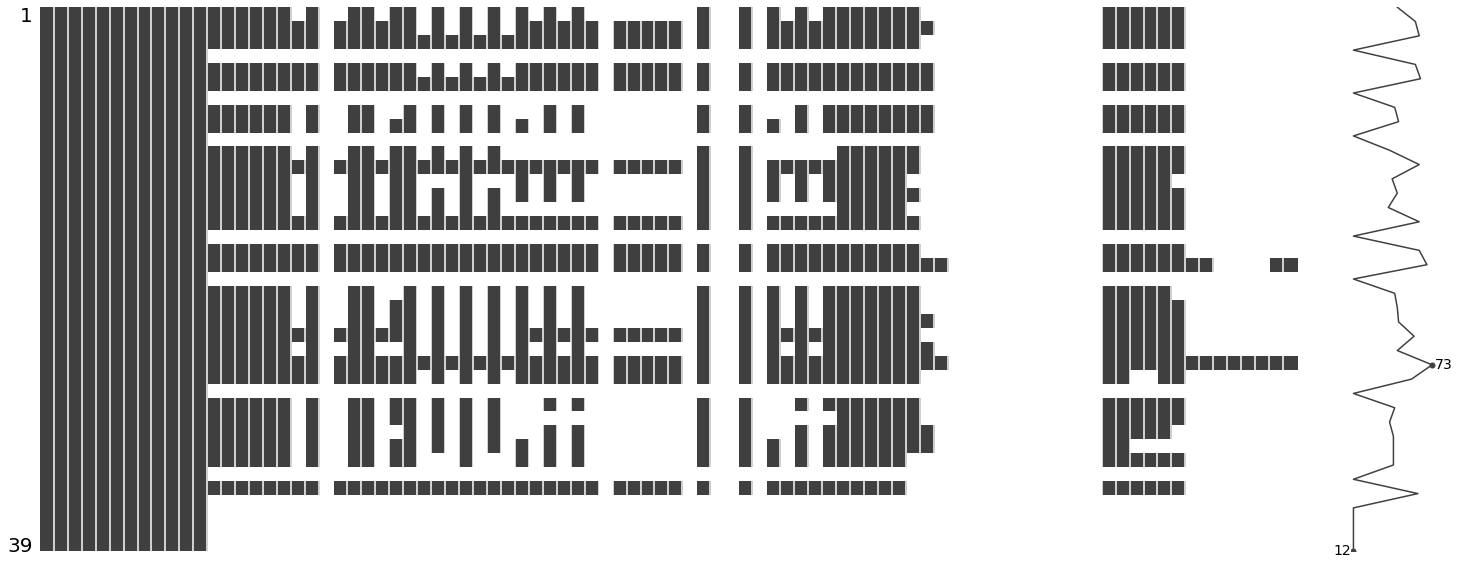

In [145]:
msg.matrix(covid_regions)

In [163]:
covid_regions_no_na = covid_regions.loc[:, covid_regions.isna().sum() < covid_regions.shape[0]]

In [164]:
covid_regions_no_na.columns

Index(['CNTRY_NAME', 'CNTRY_CODE', 'ADM1_NAME', 'ADM1_CODE', 'ADM2_NAME',
       'ADM2_CODE', 'RowcaCode1', 'RowcaCode2', 'HRname', 'HRpcode',
       'HRparent', 'geometry', 'rcode', 'hcf_name', 'reg_san', 'area_san',
       'cds_mwaterid', 'submitted_date', 'jmp_wat_svclvl', 'jmp_wat_imp',
       'jmp_wat_dist', 'wp_jmptype', 'water_available_today', 'wp_dist',
       'jmp_san_svclvl', 'jmp_san_usable', 'jmp_san_mhm', 'jmp_san_staff',
       'jmp_san_hcap', 'toilet_outpat', 'toilet_mhm', 'toilet_staff',
       'toilet_hcap', 'jmp_hyg_svclvl', 'jmp_hyg_avail', 'jmp_hyg_soap',
       'handw_today_poc', 'handw_today_toilet', 'jmp_waste_svclvl',
       'jmp_waste_sharps', 'jmp_waste_inf', 'waste_3bins', 'waste_sharps',
       'waste_infect', 'jmp_cln_prot', 'jmp_cln_prot.1', 'jmp_hyg_svclvl.1',
       'jmp_hyg_avail.1', 'jmp_hyg_soap.1', 'handw_today_poc.1',
       'handw_today_toilet.1', 'watsys_exists', 'watsys_type',
       'watsys_tank_cap', 'watsys_tank_type', 'watsys_taps',
       '

In [165]:
covid_regions.watsys_taps_total.dtype

dtype('float64')

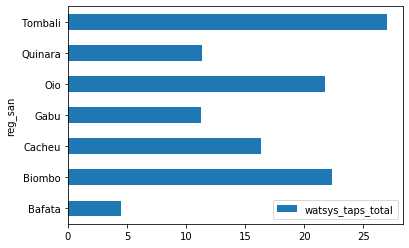

In [185]:
covid_regions_no_na.groupby('reg_san').mean().plot(kind='barh', y='watsys_taps_total')

Save modified file

In [186]:
covid_regions_no_na.to_csv(datasets / "covid_regions.csv")

**Covid UNICEF**

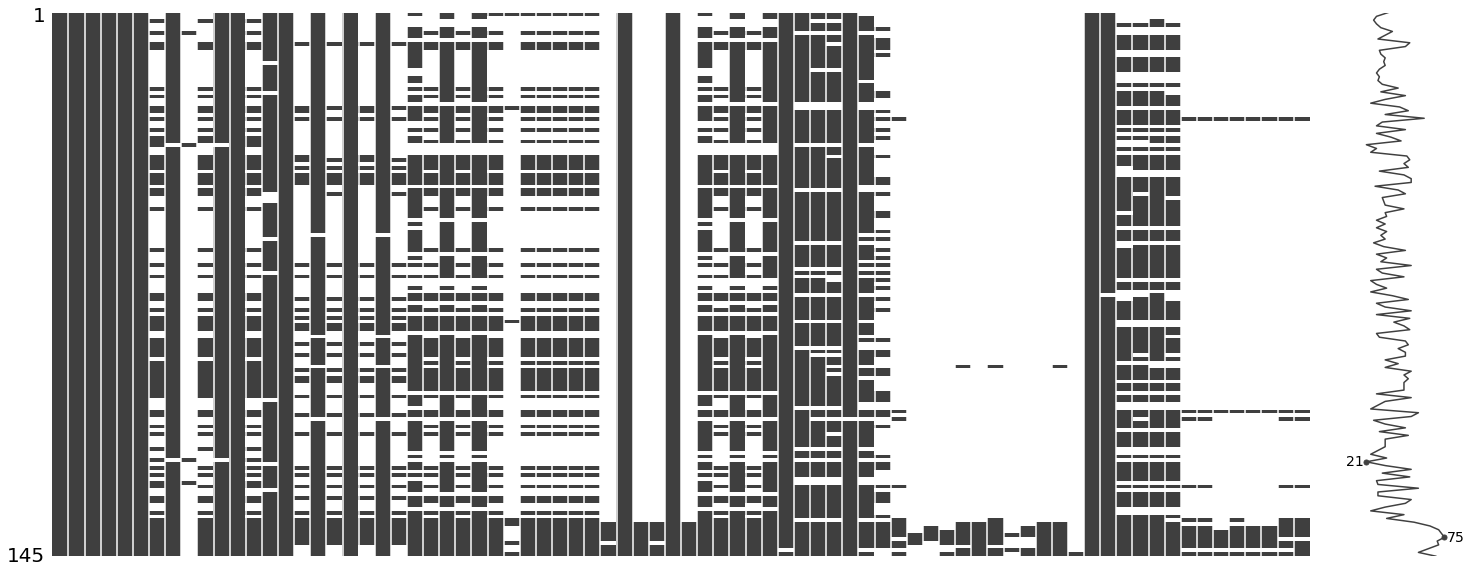

In [187]:
msg.matrix(covid_unicef)

In [188]:
covid_unicef.columns

Index(['rcode', 'hcf_name', 'reg_san', 'area_san', 'cds_mwaterid',
       'submitted_date', 'jmp_wat_svclvl', 'jmp_wat_imp', 'jmp_wat_none',
       'jmp_wat_dist', 'wp_jmptype', 'water_available_today', 'wp_dist',
       'jmp_san_svclvl', 'jmp_san_usable', 'jmp_san_mhm', 'jmp_san_staff',
       'jmp_san_hcap', 'toilet_outpat', 'toilet_mhm', 'toilet_staff',
       'toilet_hcap', 'jmp_hyg_svclvl', 'jmp_hyg_avail', 'jmp_hyg_soap',
       'handw_today_poc', 'handw_today_toilet', 'jmp_waste_svclvl',
       'jmp_waste_3bins', 'jmp_waste_sharps', 'jmp_waste_inf', 'waste_3bins',
       'waste_sharps', 'waste_infect', 'jmp_cln_svclvl', 'jmp_cln_prot',
       'jmp_cln_staff', 'jmp_cln_svclvl.1', 'jmp_cln_prot.1',
       'jmp_cln_staff.1', 'jmp_hyg_svclvl.1', 'jmp_hyg_avail.1',
       'jmp_hyg_soap.1', 'handw_today_poc.1', 'handw_today_toilet.1',
       'watsys_exists', 'watsys_type', 'watsys_tank_cap', 'watsys_tank_type',
       'watsys_taps', 'watsys_taps_total', 'watsys_taps_func',
       'reh

In [191]:
covid_unicef_no_na = covid_unicef.loc[:, covid_unicef.isna().sum() < covid_unicef.shape[0]]

In [192]:
covid_unicef_no_na.columns

Index(['rcode', 'hcf_name', 'reg_san', 'area_san', 'cds_mwaterid',
       'submitted_date', 'jmp_wat_svclvl', 'jmp_wat_imp', 'jmp_wat_none',
       'jmp_wat_dist', 'wp_jmptype', 'water_available_today', 'wp_dist',
       'jmp_san_svclvl', 'jmp_san_usable', 'jmp_san_mhm', 'jmp_san_staff',
       'jmp_san_hcap', 'toilet_outpat', 'toilet_mhm', 'toilet_staff',
       'toilet_hcap', 'jmp_hyg_svclvl', 'jmp_hyg_avail', 'jmp_hyg_soap',
       'handw_today_poc', 'handw_today_toilet', 'jmp_waste_svclvl',
       'jmp_waste_3bins', 'jmp_waste_sharps', 'jmp_waste_inf', 'waste_3bins',
       'waste_sharps', 'waste_infect', 'jmp_cln_svclvl', 'jmp_cln_prot',
       'jmp_cln_staff', 'jmp_cln_svclvl.1', 'jmp_cln_prot.1',
       'jmp_cln_staff.1', 'jmp_hyg_svclvl.1', 'jmp_hyg_avail.1',
       'jmp_hyg_soap.1', 'handw_today_poc.1', 'handw_today_toilet.1',
       'watsys_exists', 'watsys_type', 'watsys_tank_cap', 'watsys_tank_type',
       'watsys_taps', 'watsys_taps_total', 'watsys_taps_func',
       'reh

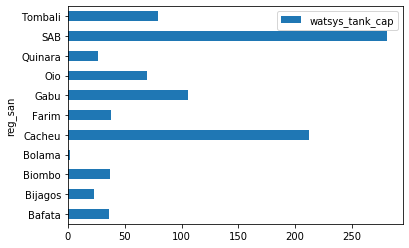

In [196]:
covid_unicef_no_na.groupby('reg_san').sum().plot(kind='barh', y='watsys_tank_cap')

Check % overlap between covid datasets

In [208]:
unicef_in_regions = covid_unicef.columns.isin(covid_regions.columns)

overlap = round(100 * unicef_in_regions.sum() / covid_regions.columns.size)

print(f'Data overlap = {overlap}%\nUNICEF data has {covid_unicef.columns.size} columns\nRegions data has {covid_regions.columns.size} columns')
print(f'All of UNICEF data captured in Regions data? {unicef_in_regions.max()}')

Data overlap = 87.0%
UNICEF data has 78 columns
Regions data has 90 columns
All of UNICEF data captured in Regions data? True
